In [1]:
import numpy as np
from numpy import exp, sqrt, pi

# QuantumSimulator Class

In [2]:
def flip_at_index(binary_string, index):
    """
    Flip the character at the specified index in a binary string.
    
    :param binary_string: A string consisting of '0's and '1's.
    :param index: The index of the character to flip.
    :return: The modified string with the character at the given index flipped.
    """
    if index < 0 or index >= len(binary_string):
        raise IndexError("Index out of range")

    # Convert the string to a list
    char_list = list(binary_string)

    # Flip the character at the specified index
    char_list[index] = '0' if char_list[index] == '1' else '1'

    # Convert the list back to a string and return
    return ''.join(char_list)

def replace_at_index(binary_string, index):
    """
    Replace the character at the specified index in a binary string with '0' and '1'.

    :param binary_string: A string consisting of '0's and '1's.
    :param index: The index of the character to replace.
    :return: Two strings, one with the character at the index replaced by '0' and the other by '1'.
    """
    if index < 0 or index >= len(binary_string):
        raise IndexError("Index out of range")

    # Convert the string to a list
    char_list = list(binary_string)

    # Create two copies of the list
    list_with_0 = char_list.copy()
    list_with_1 = char_list.copy()

    # Replace the character at the specified index
    list_with_0[index] = '0'
    list_with_1[index] = '1'

    # Convert the lists back to strings
    return ''.join(list_with_0), ''.join(list_with_1)

def round_complex(z):
    """
    Round the real and imaginary parts of a complex number to five significant figures.

    :param z: Complex number to be rounded.
    :return: Complex number with real and imaginary parts rounded to five significant figures.
    """
    return complex(round(z.real, 5), round(z.imag, 5))

# QuantumSimulator class that create a quantum circuit and simulate the effect of the quantum gates
# state vector is stored in dict, where the key correspond to the state, and the values correspond to probability amplittude
class QuantumSimulator:
    def __init__(self, N):
        """
        Initialize the attributes to describe a QuantumSimulator with number of qubits.
        """
        initial_state = '0' * N
        state_vector = {initial_state : 1}
        self.state = state_vector
    
    # apply x gate on the target 
    def x(self, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            new_key = flip_at_index(new_key, target)
            new_state[new_key] = new_value
        self.state = new_state

    # apply h gate on the target
    def h(self, target):
        new_state = {}
        for key, value in self.state.items():
            factor = 1
            if key[target] == '1':
                factor = -1
            new_key1, new_key2 = replace_at_index(key, target)
            new_state[new_key1] = round_complex(1/sqrt(2)*value + new_state.get(new_key1, complex(0)))
            new_state[new_key2] = round_complex(factor*1/sqrt(2)*value + new_state.get(new_key2, complex(0)))
        self.state = new_state
    
    # apply t gate on the target
    def t(self, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if new_key[target] == '1':
                new_value = round_complex(np.exp(1j*pi/4)*new_value)
            new_state[new_key] = new_value
        self.state = new_state      
    
    # apply tdg gate on the target
    def t_dag(self, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if new_key[target] == '1':
                new_value = round_complex(np.exp(-1j*pi/4)*new_value)
            new_state[new_key] = new_value
        self.state = new_state  

    # apply cx gate based on the control on the target
    def cx(self, control, target):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if new_key[control] == '1':
                new_key = flip_at_index(new_key, target)
            new_state[new_key] = new_value
        self.state = new_state
    
    # clean up the state with 0 probability
    def clean(self):
        new_state = {}
        for key, value in self.state.items():
            new_key, new_value = key, value
            if np.abs(value) != 0:
                new_state[new_key] = new_value
        self.state = new_state
    
    # clean the state and return state_vector output
    def state_out(self):
        self.clean()
        return self.state
    

# Parsing QASM file and get state

In [3]:
import re

# helper functions

def parse_operation(s):
    """
    Parse a string operation and return a list with the operation and qubit indices.

    :param s: A string representing the operation, e.g., 'cx q[0],q[1];'
    :return: A list containing the operation name and qubit indices as integers.
    """
    # Extract operation name (assuming it's always the first word)
    operation = s.split()[0]

    # Find all occurrences of numbers in square brackets
    indices = [int(num) for num in re.findall(r'\[([0-9]+)\]', s)]

    # Combine operation with indices
    return [operation] + indices

def find_max_integer_in_string_below_n(s, n):
    """
    Find the maximum integer in a given string that is less than a specified value n.

    :param s: Input string
    :param n: The upper limit value
    :return: Maximum integer found in the string below n, or None if no such integers are present
    """
    # Extract all integers from the string
    numbers = [int(num) for num in re.findall(r'\d+', s)]

    # Filter out numbers that are greater than or equal to n
    numbers_below_n = [num for num in numbers if num < n]

    # Return the maximum number if the filtered list is not empty, otherwise return None
    return max(numbers_below_n) if numbers_below_n else None

# accept .qasm file as a string input
# execute the gate from the string input
# return state vector output
def parser(file_str):
    operation = 0
    num_qubits = 0

    # Split the content into lines
    lines = file_str.splitlines()

    # get the number of qubits
    for line in lines:
        operation = parse_operation(line)
        if operation[0] == 'qreg':
            num_qubits = operation[1]
            break

    # create quantum circuit
    num_qubits = find_max_integer_in_string_below_n(file_str, num_qubits) + 1
    qc = QuantumSimulator(num_qubits)

    # apply operation
    for line in lines:
        operation = parse_operation(line)
        gate = operation[0]
        if gate == 'x':
            qc.x(operation[1])
        elif gate == 'cx':
            qc.cx(operation[1], operation[2])
        elif gate == 't':
            qc.t(operation[1])
        elif gate == 'tdg':
            qc.t_dag(operation[1])
        elif gate == 'h':
            qc.h(operation[1])
        
    return qc.state_out()

# get the simulated result in cirq format
def simulate(file_str):
    output = parser(file_str)
    states = list(output.keys())
    state = states[0]
    decimal = int(state, 2)
    cirq_array = [0] * (2**len(state))
    cirq_array[decimal] = 1
    return cirq_array


In [4]:
import glob

# List all files ending with '.qasm'
qasm_files = glob.glob('*.qasm')

for name in qasm_files:
    with open(name, 'r') as f:
        file = f.read()
    print(name)
    print(parser(file))

con1_216.qasm
{'100101110': (1+0j)}
mini_alu_305.qasm
{'0000000110': (1+0j)}
sym6_316.qasm
{'00000000000010': (1+0j)}
miller_11.qasm
{'000': (1+0j)}
one-two-three-v3_101.qasm
{'11000': (1+0j)}
hwb5_53.qasm
{'000000': (1+0j)}
cm152a_212.qasm
{'011100000000': (1+0j)}
squar5_261.qasm
{'0000000011011': (1+0j)}
rd84_142.qasm
{'000000000000000': (1+0j)}
f2_232.qasm
{'00000110': (1+0j)}
alu-bdd_288.qasm
{'0000001': (1+0j)}
decod24-v2_43.qasm
{'0001': (1+0j)}
cnt3-5_179.qasm
{'0000000000000000': (1+0j)}
wim_266.qasm
{'11011111111': (1+0j)}


# Observe runtime as gate numbers grow

In [37]:
import time

def my_function(gate_num):
    qc = QuantumSimulator(1)
    for i in range(gate_num):
        qc.h(0)

# Number of times you want to run the function
num_runs = 500

# List to store runtimes
runtimes = []

for i in range(num_runs):
    start_time = time.time()  # Start time
    my_function(i)             # Run the function
    end_time = time.time()    # End time

    # Calculate and store the runtime
    runtime = end_time - start_time
    runtimes.append(runtime)

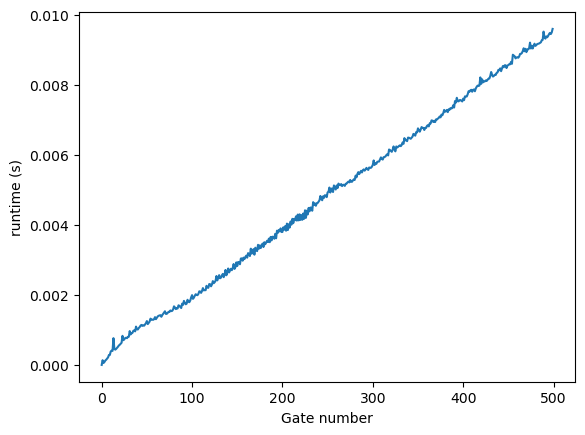

In [39]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(num_runs)], runtimes)
plt.xlabel('Gate number')
plt.ylabel('runtime (s)')
plt.show()

# Observe runtime as Qubit numbers grow

In [40]:
def my_function(qubit_num):
    qc = QuantumSimulator(qubit_num)
    for i in range(qubit_num):
        qc.h(i)

# Number of times you want to run the function
qubit_num = 25

# List to store runtimes
runtimes = []

for i in range(1, qubit_num):
    start_time = time.time()  # Start time
    my_function(i)             # Run the function
    end_time = time.time()    # End time

    # Calculate and store the runtime
    runtime = end_time - start_time
    runtimes.append(runtime)

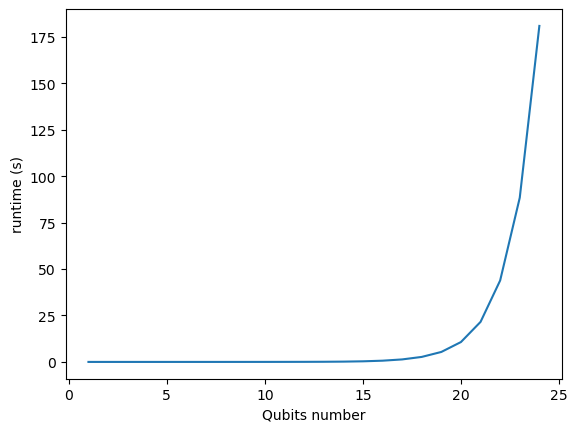

In [41]:
plt.plot([i for i in range(1, qubit_num)], runtimes)
plt.xlabel('Qubits number')
plt.ylabel('runtime (s)')
plt.show()

# additonal testing

In [42]:
qc = QuantumSimulator(2)
qc.h(0)
qc.cx(0,1)
print(qc.state_out())

{'00': (0.70711+0j), '11': (0.70711+0j)}


In [43]:
qc = QuantumSimulator(3)
qc.h(0)
qc.h(1)
qc.h(2)
print(qc.state_out())

{'000': (0.35355+0j), '001': (0.35355+0j), '010': (0.35355+0j), '011': (0.35355+0j), '100': (0.35355+0j), '101': (0.35355+0j), '110': (0.35355+0j), '111': (0.35355+0j)}


In [44]:
qc = QuantumSimulator(3)
qc.h(0)
qc.h(1)
qc.h(2)
qc.cx(0, 1)
print(qc.state_out())

{'000': (0.35355+0j), '001': (0.35355+0j), '010': (0.35355+0j), '011': (0.35355+0j), '110': (0.35355+0j), '111': (0.35355+0j), '100': (0.35355+0j), '101': (0.35355+0j)}


In [46]:
qc = QuantumSimulator(1)
qc.x(0)
qc.t(0)
qc.t(0)
qc.t(0)
qc.t(0)
print(qc.state_out())

{'1': (-1+0j)}


In [47]:
qc = QuantumSimulator(1)
qc.x(0)
qc.t(0)
qc.t_dag(0)
print(qc.state_out())

{'1': (1+0j)}
